# Diatom analysis

See https://www.nature.com/articles/s41524-019-0202-3:

**Deep data analytics for genetic engineering of diatoms linking genotype to phenotype via machine learning**, Artem A. Trofimov, Alison A. Pawlicki, Nikolay Borodinov, Shovon Mandal, Teresa J. Mathews, Mark Hildebrand, Maxim A. Ziatdinov, Katherine A. Hausladen, Paulina K. Urbanowicz, Chad A. Steed, Anton V. Ievlev, Alex Belianinov, Joshua K. Michener, Rama Vasudevan, and Olga S. Ovchinnikova.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set up matplotlib defaults: larger images, gray color map
import matplotlib
matplotlib.rcParams.update({
    'figure.figsize': (10, 10),
    'image.cmap': 'gray'
})

In [ ]:
from skimage import io, color
image = io.imread(r'C:\Users\tobi1\OneDrive\S4_Uni_Tilburg\Image_Analysis_RS\Exercises_Github\Image_Analysis_scikit-image\Official_Tutorials\skimage-tutorials\data\diatom-wild-032.jpg')
t = 0.325 #apply ml to learn this

# image = io.imread(r'C:\Users\tobi1\OneDrive\S4_Uni_Tilburg\Image_Analysis_RS\Exercises_Github\Image_Analysis_scikit-image\Assignment\images\2111832_vesselimage.jpg')
# image = color.rgb2gray(image)
# t = 0.47 #apply ml to learn this

plt.imshow(image);

In [ ]:
pores = image[:690, :]

plt.imshow(pores);

In [6]:
from scipy import ndimage as ndi
from skimage import util

denoised = ndi.median_filter(util.img_as_float(pores), size=3)

In [ ]:
plt.imshow(denoised);

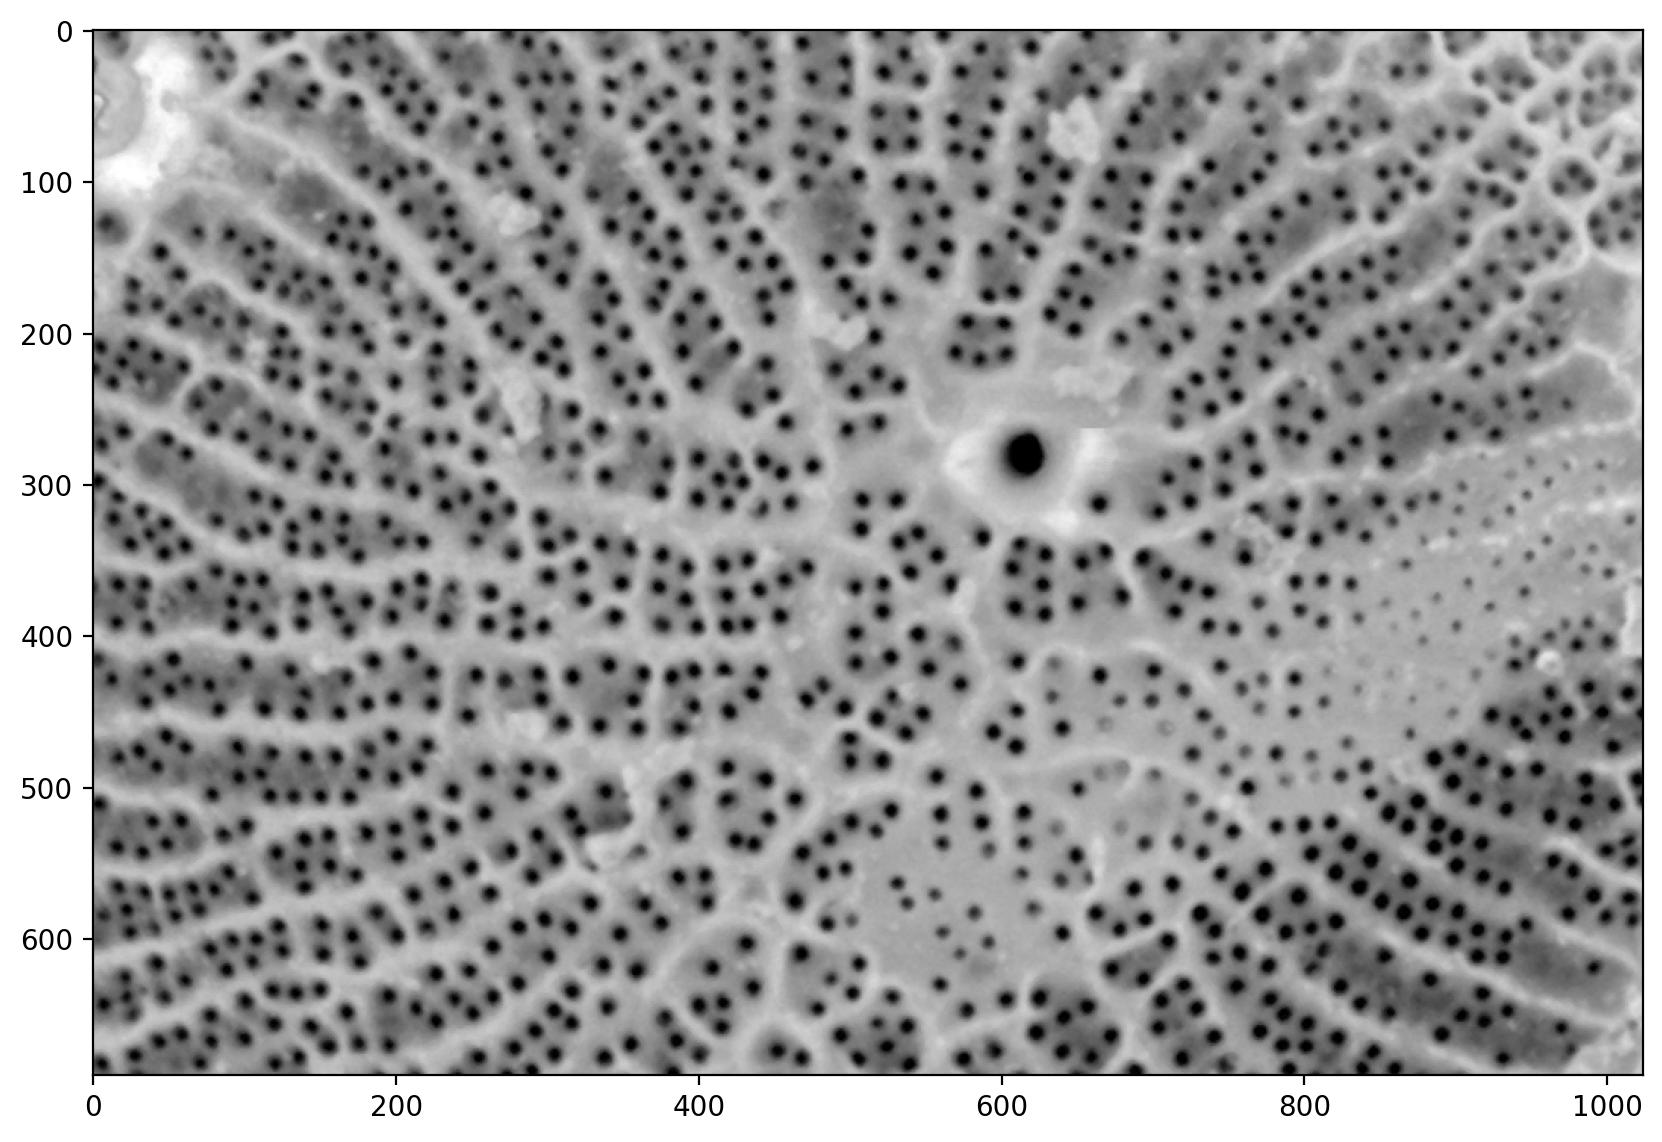

In [8]:
from skimage import exposure

pores_gamma = exposure.adjust_gamma(denoised, 0.7)
plt.imshow(pores_gamma);

In [ ]:
pores_gamma = exposure.equalize_adapthist(pores_gamma, clip_limit=0.005) 
plt.imshow(pores_gamma);

In [ ]:
pores_inv = 1 - pores_gamma
plt.imshow(pores_inv);

In [11]:
np.max(pores_inv)

1.0

In [12]:
np.min(pores_inv)

0.0

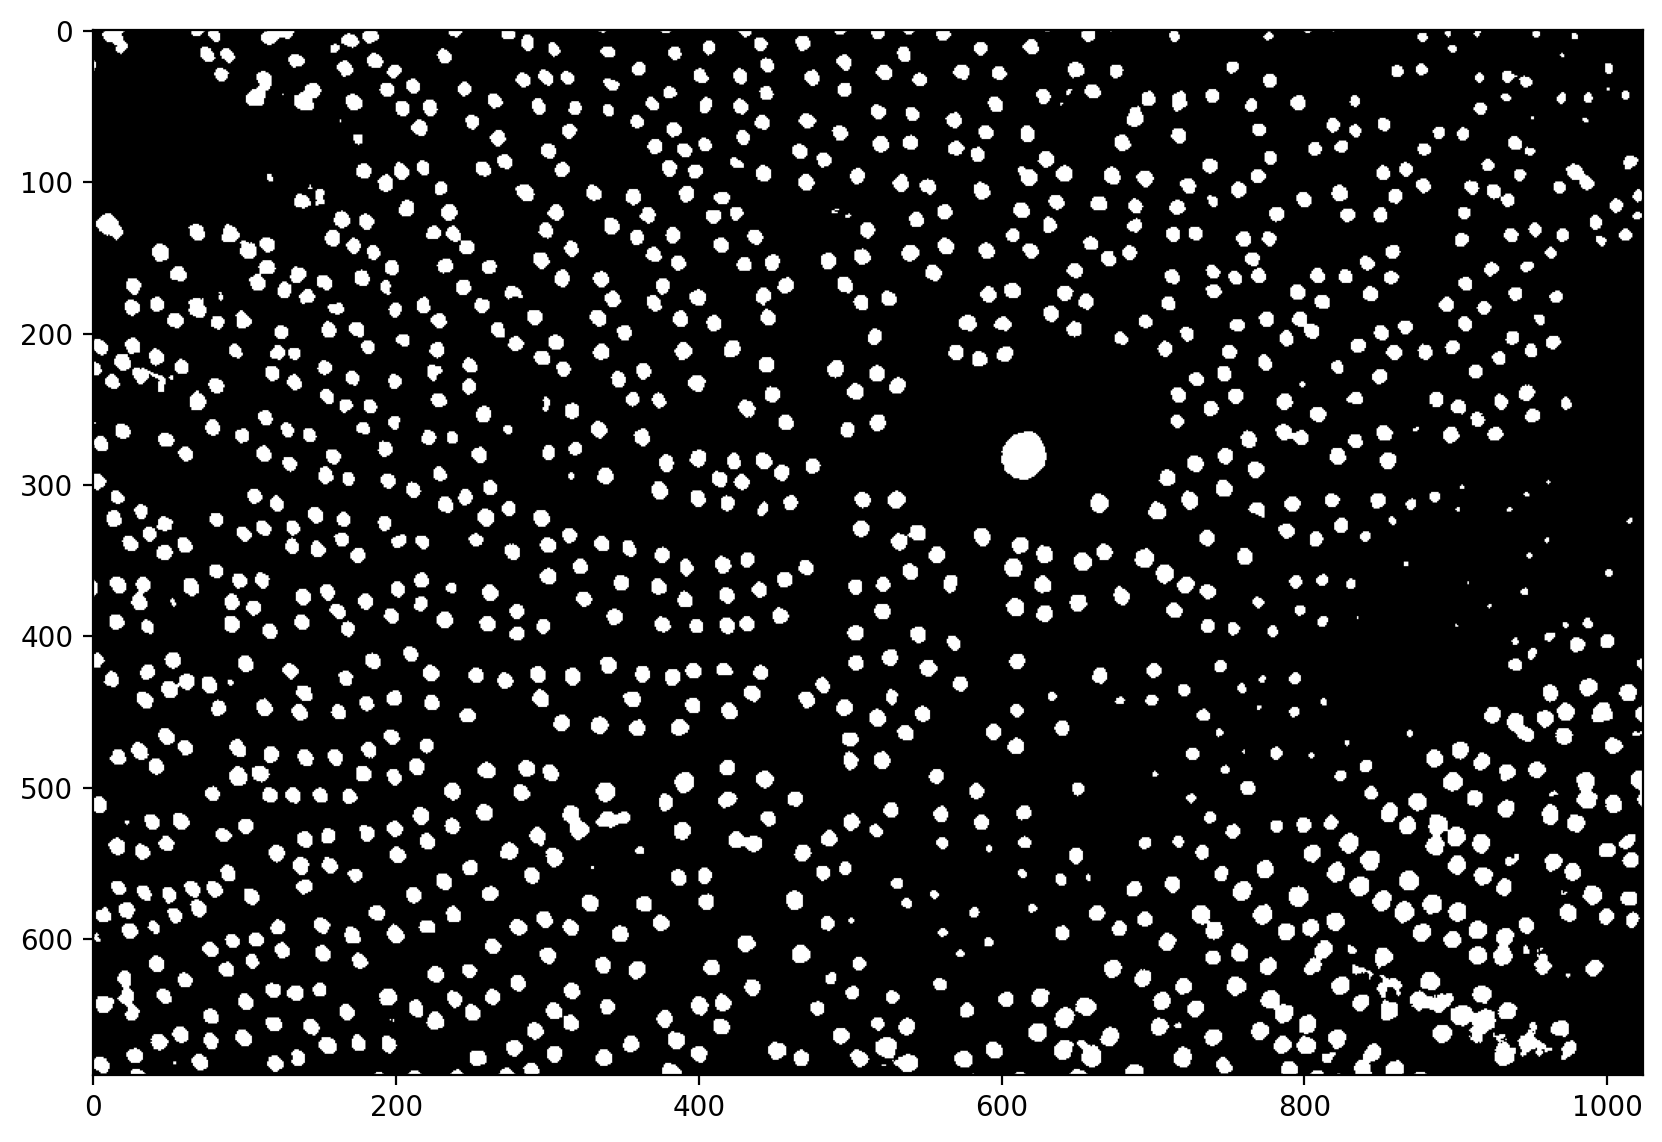

In [13]:
# This is the problematic part of the manual pipeline: you need
# a good segmentation.  There are algorithms for automatic thresholding,
# such as `filters.otsu` and `filters.li`, but they don't always get the
# result you want.

# t = 0.47 #apply ml to learn this

thresholded = (pores_gamma <= t)

plt.imshow(thresholded);

In [ ]:
from skimage import filters

filters.try_all_threshold(pores_gamma, figsize=(15, 20));

In [15]:
from skimage import segmentation, morphology, color

In [ ]:
distance = ndi.distance_transform_edt(thresholded)

plt.imshow(exposure.adjust_gamma(distance, 0.5))
plt.title('Distance to background map');

In [17]:
local_maxima = morphology.local_maxima(distance)

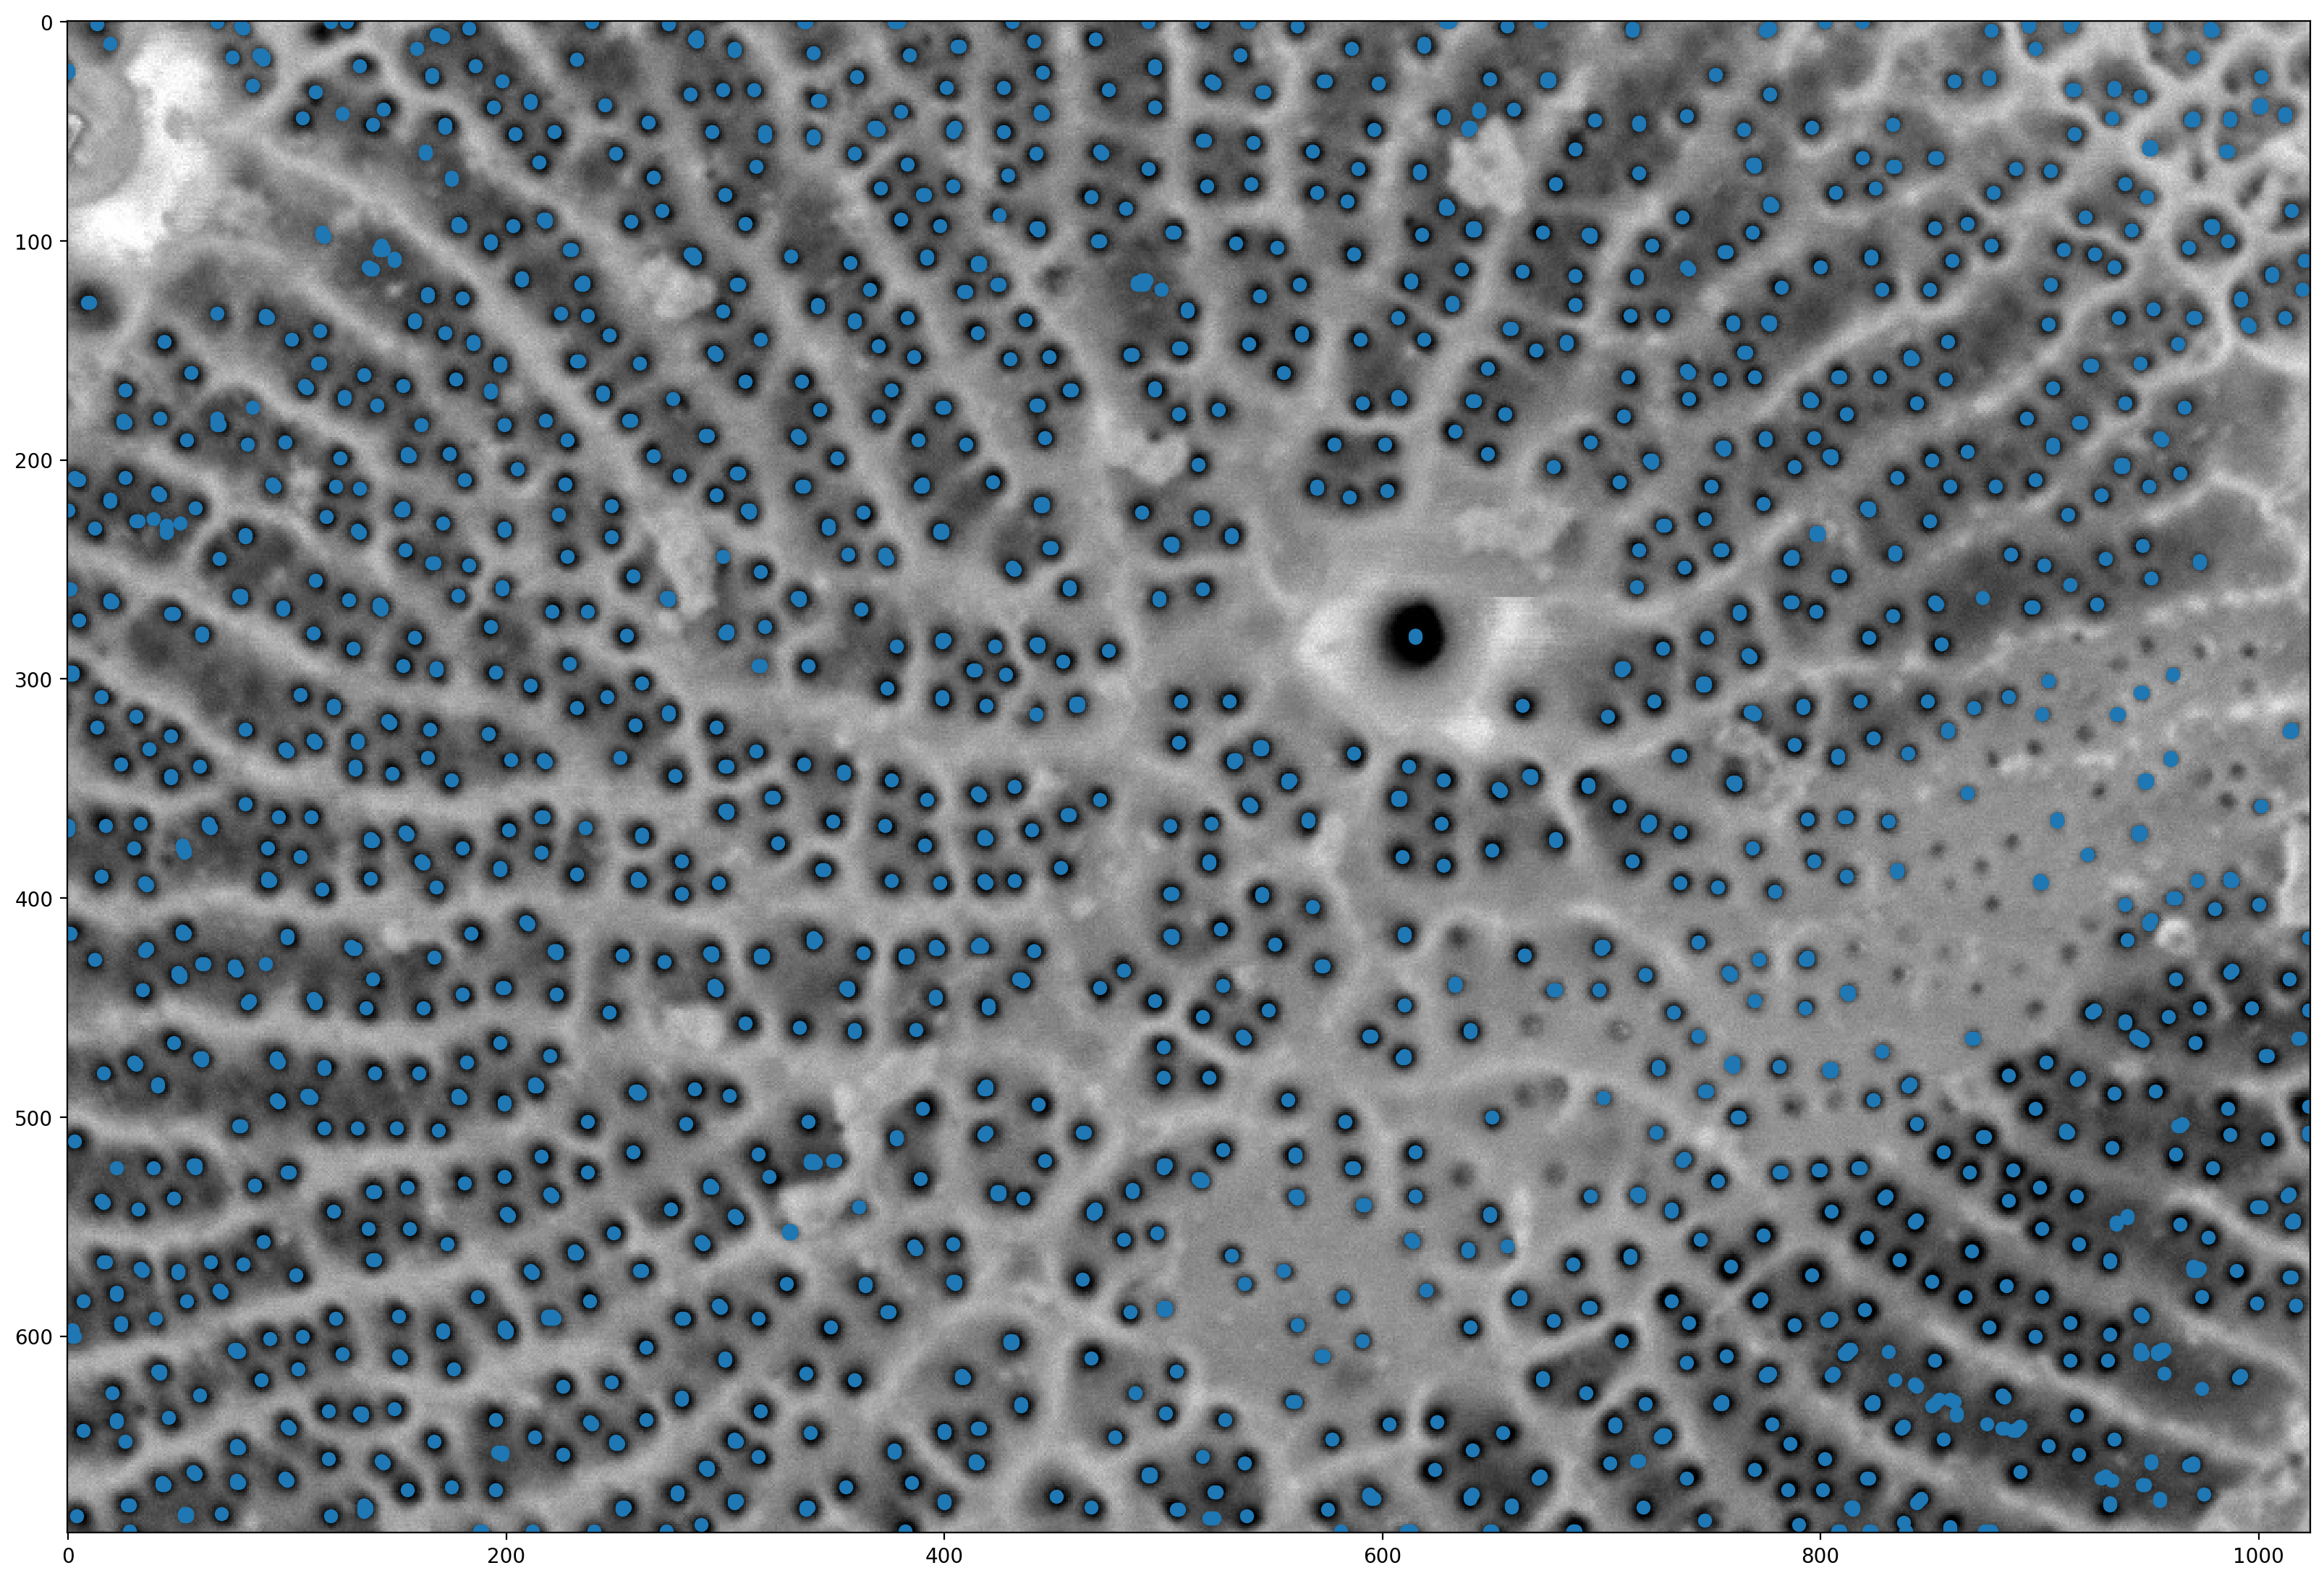

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))

maxi_coords = np.nonzero(local_maxima)

ax.imshow(pores);
plt.scatter(maxi_coords[1], maxi_coords[0]);

In [19]:
# This is a utility function that we'll use for display in a while;
# you can ignore it for now and come and investigate later.

def shuffle_labels(labels):
    """Shuffle the labels so that they are no longer in order.
    This helps with visualization.
    """
    indices = np.unique(labels[labels != 0])
    indices = np.append(
        [0],
        np.random.permutation(indices)
    )
    return indices[labels]

In [20]:
markers = ndi.label(local_maxima)[0]
labels = segmentation.watershed(denoised, markers)

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))
ax0.imshow(thresholded)
ax1.imshow(np.log(1 + distance))
ax2.imshow(shuffle_labels(labels), cmap='magma');

In [22]:
labels_masked = segmentation.watershed(thresholded, markers, mask=thresholded, connectivity=2)

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))
ax0.imshow(thresholded)
ax1.imshow(np.log(1 + distance))
ax2.imshow(shuffle_labels(labels_masked), cmap='magma');

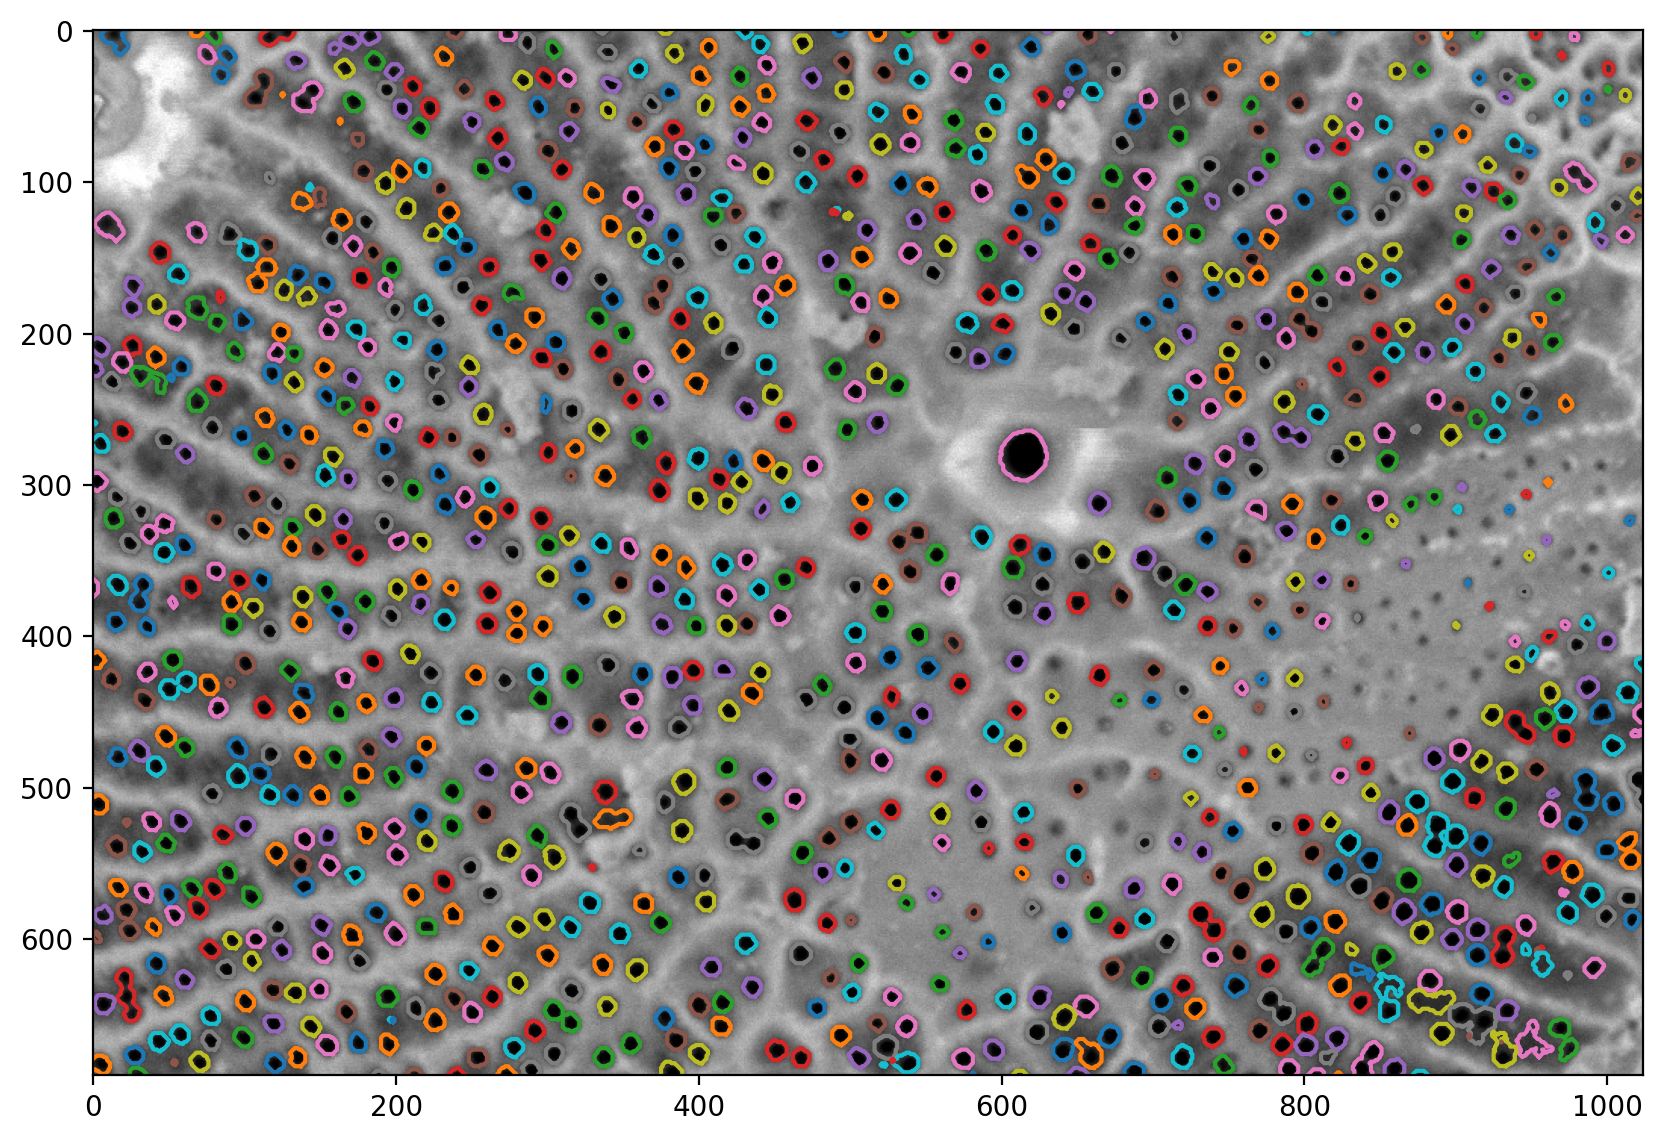

In [24]:
from skimage import measure

contours = measure.find_contours(labels_masked, level=0.5)
plt.imshow(pores)
for c in contours:
    plt.plot(c[:, 1], c[:, 0])

In [25]:
regions = measure.regionprops(labels_masked)

In [ ]:
f, ax = plt.subplots(figsize=(10, 3))
ax.hist([r.area for r in regions], bins=100, range=(0, 200));

In [27]:
from keras import models, layers
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

M = 76
N = int(23 / 76 * M) * 2

model = models.Sequential()
model.add(
    Conv2D(
        32,
        kernel_size=(2, 2),
        activation='relu',
        input_shape=(N, N, 1),
        padding='same'
    )
)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(2, 2)))
model.add(
    Conv2D(
        1,
        kernel_size=(2, 2),
        activation='sigmoid',
        padding='same'
    )
)
model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

# Load pre-trained weights from disk
model.load_weights('../data/keras_model-diatoms-pores.h5')

ModuleNotFoundError: No module named 'keras'

In [ ]:
shape = np.array(pores.shape)
padded_shape = (np.ceil(shape / 46) * 46).astype(int)
delta_shape = padded_shape - shape

padded_pores = np.pad(
    pores,
    pad_width=[(0, delta_shape[0]), (0, delta_shape[1])],
    mode='symmetric'
)

blocks = util.view_as_blocks(padded_pores, (46, 46))

In [ ]:
B_rows, B_cols, _, _ = blocks.shape

tiles = blocks.reshape([-1, 46, 46])

# `predict` wants input of shape (N, 46, 46, 1)
tile_masks = model.predict_classes(tiles[..., np.newaxis])

print(tile_masks.shape)
tile_masks = tile_masks[..., 0].astype(bool)
print(tile_masks.shape)

In [ ]:
nn_mask = util.montage(tile_masks, grid_shape=(B_rows, B_cols))
nn_mask = nn_mask[:shape[0], :shape[1]]

In [ ]:
plt.imshow(nn_mask);

In [ ]:
contours = measure.find_contours(nn_mask, level=0.5)
plt.imshow(pores)
for c in contours:
    plt.plot(c[:, 1], c[:, 0])

In [ ]:
nn_regions = measure.regionprops(
    measure.label(nn_mask)
)

In [ ]:
f, ax = plt.subplots(figsize=(10, 3))
ax.hist([r.area for r in regions], bins='auto', range=(0, 200), alpha=0.4, label='Classic')
ax.hist([r.area for r in nn_regions], bins='auto', range=(0, 200), alpha=0.4, label='NN')
ax.legend();

## Bonus round: region filtering

remove shapes that are not circular

In [ ]:
def is_circular(regions, eccentricity_threshold=0.1, area_threshold=10):
    """Calculate a boolean mask indicating which regions are circular.
    
    Parameters
    ----------
    eccentricity_threshold : float, >= 0
        Regions with an eccentricity less than than this value are
        considered circular. See `measure.regionprops`.
    area_threshold : int
        Only regions with an area greater than this value are considered
        circular.
    """
    return np.array([
        (r.area > area_threshold) and
        (r.eccentricity <= eccentricity_threshold)
        for r in regions
    ])

In [ ]:
def filtered_mask(mask, regions, eccentricity_threshold, area_threshold):
    mask = mask.copy()
    suppress_regions = np.array(regions)[
        ~is_circular(
            regions,
            eccentricity_threshold=eccentricity_threshold,
            area_threshold=area_threshold
        )
    ]
    
    for r in suppress_regions:
        mask[tuple(r.coords.T)] = 0
        
    return mask

In [ ]:
plt.imshow(filtered_mask(nn_mask, nn_regions,
                         eccentricity_threshold=0.8,
                         area_threshold=20));

In [ ]:
contours = measure.find_contours(
    filtered_mask(nn_mask, nn_regions,
                  eccentricity_threshold=0.8,
                  area_threshold=20),
    level=0.5
)
plt.imshow(pores)
for c in contours:
    plt.plot(c[:, 1], c[:, 0])

In [ ]:
filtered_regions = np.array(nn_regions)[is_circular(nn_regions, 0.8, 20)]

f, ax = plt.subplots(figsize=(10, 3))
ax.hist([r.area for r in filtered_regions], bins='auto', range=(0, 200), alpha=0.4);